In [3]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from imblearn.combine import SMOTETomek
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

print("All libraries loaded")

All libraries loaded


In [4]:
try:
    data = pd.read_excel('informacion_completa_imagenes.xlsx')
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    
# print(data.head())
print(data.info())

Datos cargados exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nombre de la imagen               214 non-null    object 
 1   Ángulo entre manecillas           214 non-null    float64
 2   Ángulo manecillas 2pm             214 non-null    float64
 3   Ángulo manecillas 11am            214 non-null    float64
 4   Lowest point                      214 non-null    object 
 5   longitud_manecilla_2pm            214 non-null    float64
 6   longitud_manecilla_11am           214 non-null    float64
 7   Números detectados correctamente  214 non-null    int64  
 8   Números con error espacial        214 non-null    int64  
 9   Números algo detectado            214 non-null    int64  
 10  Total numeros detectados          214 non-null    int64  
 11  Puntuacion contorno               214 non-

In [5]:
data = data.astype({col: 'float64' for col in data.select_dtypes(include='bool').columns})
data[['lowest_point_x', 'lowest_point_y']] = data['Lowest point'].str.strip('()').str.split(',', expand=True).astype(float)
data['longitud_relativa_2pm'] = data['longitud_manecilla_2pm' ] / data['Area Circulo']
data['longitud_relativa_11pm'] = data['longitud_manecilla_11am' ] / data['Area Circulo']

data.drop(columns=['nombre de la imagen','longitud_manecilla_2pm','longitud_manecilla_11am','Lowest point'],inplace=True)


data = data[data['Tipo'] != 'PR']
data.dropna(subset=['Tipo'], inplace=True)

data['Tipo'] = data['Tipo'].map({'PD': 0, 'HC': 1})
data['Tipo'].fillna(0, inplace=True)

data = data.dropna()

conteo_clases = data['Tipo'].value_counts()
print(conteo_clases)
print(data.info())

Tipo
0    140
1     44
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, 0 to 213
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           184 non-null    float64
 1   Ángulo manecillas 2pm             184 non-null    float64
 2   Ángulo manecillas 11am            184 non-null    float64
 3   Números detectados correctamente  184 non-null    int64  
 4   Números con error espacial        184 non-null    int64  
 5   Números algo detectado            184 non-null    int64  
 6   Total numeros detectados          184 non-null    int64  
 7   Puntuacion contorno               184 non-null    int64  
 8   Puntuacion manecillas             184 non-null    int64  
 9   Puntuacion numeros                184 non-null    int64  
 10  puntuacion final                  184 non-null    int64  
 11  Area Circulo               

In [6]:
X = data.drop(columns=['Tipo'])
y = data['Tipo']

X = X.dropna()
y = y[X.index]


numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, 0 to 213
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           184 non-null    float64
 1   Ángulo manecillas 2pm             184 non-null    float64
 2   Ángulo manecillas 11am            184 non-null    float64
 3   Números detectados correctamente  184 non-null    int64  
 4   Números con error espacial        184 non-null    int64  
 5   Números algo detectado            184 non-null    int64  
 6   Total numeros detectados          184 non-null    int64  
 7   Puntuacion contorno               184 non-null    int64  
 8   Puntuacion manecillas             184 non-null    int64  
 9   Puntuacion numeros                184 non-null    int64  
 10  puntuacion final                  184 non-null    int64  
 11  Area Circulo                      184 non-null    float64
 12  Circularidad 

Datos de entrenamiento: (134, 21), Datos de validación: (58, 21), Datos de prueba ciega: (37, 21)


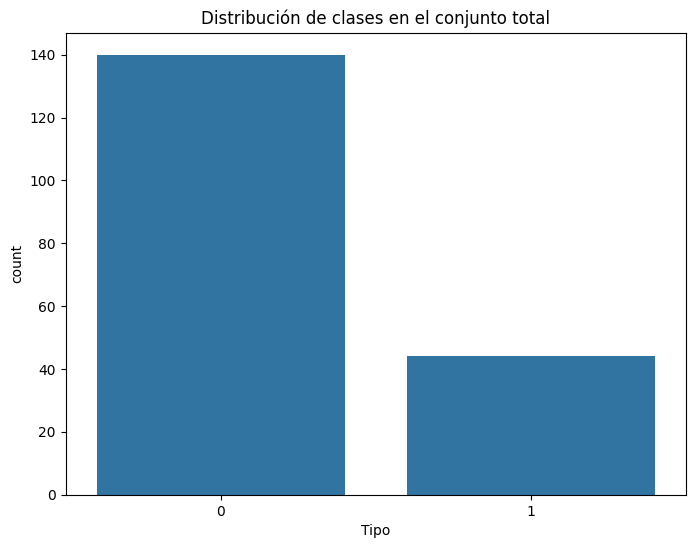

Tipo
0    140
1     44
Name: count, dtype: int64


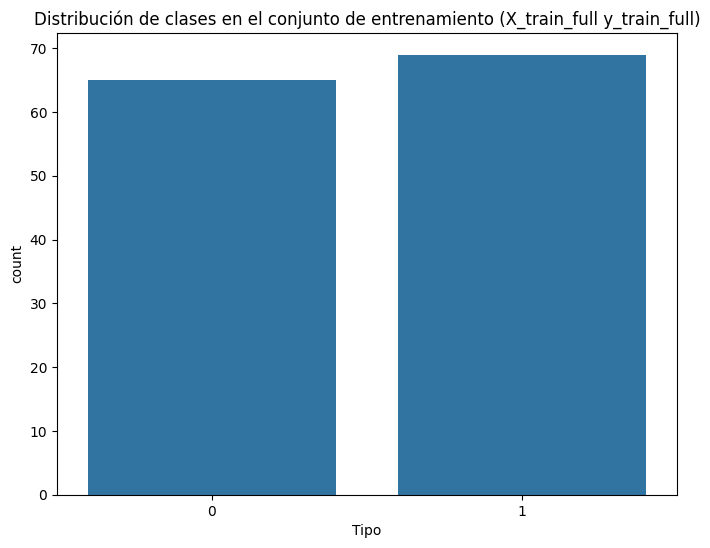

Tipo
0    109
1     38
Name: count, dtype: int64


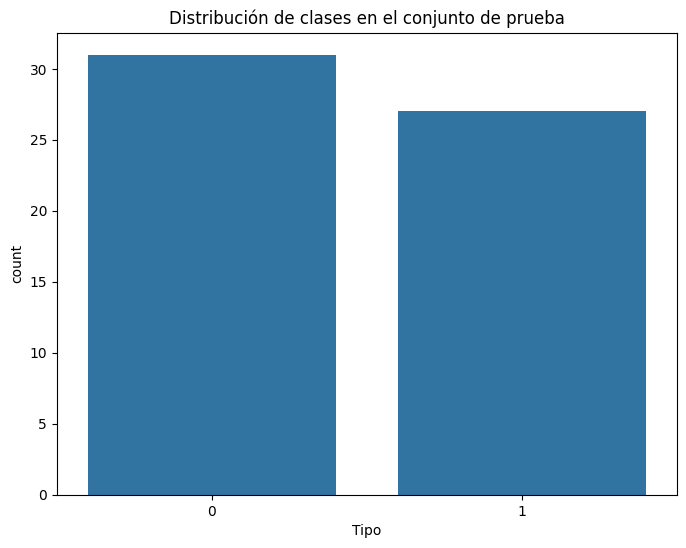

Tipo
0    31
1    27
Name: count, dtype: int64


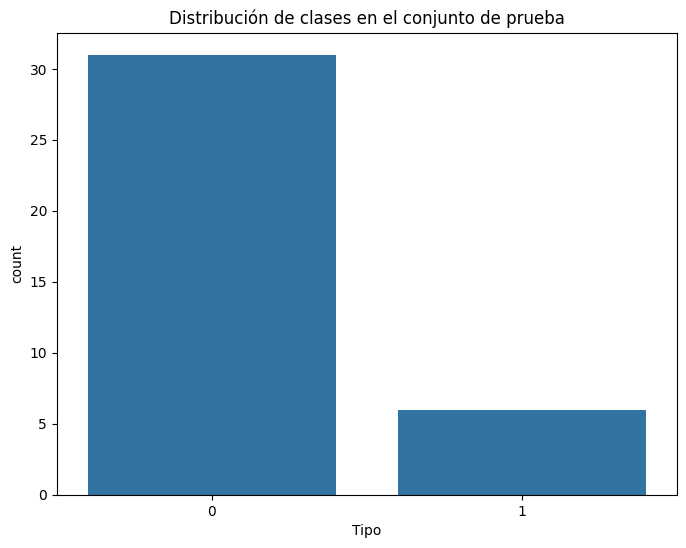

Tipo
0    31
1    27
Name: count, dtype: int64


In [7]:
X_train, X_test_blind, y_train, y_test_blind = train_test_split(X, y, test_size=0.2, random_state=42)  

smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


print(f"Datos de entrenamiento: {X_train_full.shape}, Datos de validación: {X_test_full.shape}, Datos de prueba ciega: {X_test_blind.shape}")

plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title('Distribución de clases en el conjunto total')
plt.show()
print(y.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_train_full)
plt.title('Distribución de clases en el conjunto de entrenamiento (X_train_full y_train_full)')
plt.show()
print(y_train.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_full)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_blind)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_full.value_counts())

In [14]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid = {
    'svm__C': np.logspace(-3, 3, 7),  
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
    'svm__degree': [2, 3, 4, 5], 
    'svm__coef0': [0, 0.1, 0.5, 1], 
    'svm__class_weight': [None, 'balanced']  
}

scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    scoring=scorers, 
    refit='f1', 
    cv=5,  
    n_jobs=-1
)

In [15]:
grid_search.fit(X_train_full, y_train_full)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
y_pred = grid_search.predict(X_test_full)

print(classification_report(y_test_full, y_pred))

Mejores hiperparámetros: {'svm__C': 10.0, 'svm__class_weight': None, 'svm__coef0': 0, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        31
           1       0.85      0.85      0.85        27

    accuracy                           0.86        58
   macro avg       0.86      0.86      0.86        58
weighted avg       0.86      0.86      0.86        58



In [16]:
import joblib
joblib.dump(grid_search.best_estimator_, 'SVM_model.pkl')

['SVM_model.pkl']